In [1]:
import os
from voc12 import my_dataloader
from utility import image_util, util
from torch.utils.data import DataLoader
import torch
from misc import imutils
import importlib
import torch.nn.functional as F
import numpy as np
import importlib
import voc12.dataloader
import importlib

In [2]:
cam_network = "net.resnet50_cam"
crop_cam_weights_name = "../sess/voc_sess/resnet50_crop_cam"
cam_weights_name = "../sess/voc_sess/resnet50_cam"
trainval_list = "voc12/val.txt"
voc12_root = "../Dataset/VOC2012/"
cam_root = "../irn_result/cam"
cam_scales = (1.0, 0.5, 1.5, 2.0)
device = "cuda:1"

In [3]:
model = getattr(importlib.import_module(cam_network), 'CAM')()
model.load_state_dict(torch.load(crop_cam_weights_name + '.pth'), strict=True)        
model.eval()
    
dataset = my_dataloader.VOC12_CropClassificationDatasetMSF(trainval_list, voc12_root = voc12_root,
                                                          cam_root = cam_root, scales=cam_scales)

100%|██████████| 2913/2913 [00:08<00:00, 353.68it/s]


In [4]:
data_loader = DataLoader(dataset)

pack = next(iter(data_loader))

In [5]:
with torch.no_grad():
    model = model.to(device)
    
    img_name = pack['name'][0]
    msf = pack['msf_img_list']
    org_size = pack['size']
    strided_org_size = imutils.get_strided_size(org_size, 4)
    
    crop_labels = pack['crop_labels']
    crop_boxes = pack['crop_boxes']
    crop_boxes = [tuple(int(t.item()) for t in crop_box) for crop_box in crop_boxes]
    
    strided_crop_boxes = image_util.resize_bbox_list(crop_boxes, org_size, strided_org_size)
    
    cam_list = []
    highres_cam_list = []

    key = torch.sum(torch.cat(crop_labels, dim=0), dim=0)
    key = torch.nonzero(key)[:, 0]
    for idx, msf_img in enumerate(msf):
        
        msf_img = msf[idx]
        label = crop_labels[idx][0]
        
        size = (crop_boxes[idx][3] - crop_boxes[idx][1], crop_boxes[idx][2] - crop_boxes[idx][0])
        
        strided_size = imutils.get_strided_size(size, 4)
        strided_up_size = imutils.get_strided_up_size(size, 16)
        
        valid_cat = torch.nonzero(label)[:, 0]
        
        outputs = [model(img[0].to(device)) for img in msf_img]
        
        strided_cam = torch.sum(torch.stack(
        [F.interpolate(torch.unsqueeze(o, 0), strided_size, mode='bilinear', align_corners=False)[0] for o
            in outputs]), 0)
        
        highres_cam = [F.interpolate(torch.unsqueeze(o, 1), strided_up_size,
                                    mode='bilinear', align_corners=False) for o in outputs]

        
        highres_cam = torch.sum(torch.stack(highres_cam, 0), 0)[:, 0, :size[0], :size[1]]
        
        highres_cam = highres_cam[valid_cat]
        highres_cam /= F.adaptive_max_pool2d(highres_cam, (1, 1)) + 1e-5
        
        strided_cam = strided_cam[valid_cat]
        strided_cam /= F.adaptive_max_pool2d(strided_cam, (1, 1)) + 1e-5
        
        strided_cam = strided_cam[0].cpu().numpy()
        highres_cam = highres_cam[0].cpu().numpy()
        
        strided_cam = image_util.crop_cam_to_org_cam(strided_cam, strided_crop_boxes[idx], strided_org_size)
        highres_cam = image_util.crop_cam_to_org_cam(highres_cam, crop_boxes[idx], org_size)

        cam_list.append(strided_cam)
        highres_cam_list.append(highres_cam)
    
    cam_stack = np.stack(cam_list)
    
    cam_stack = torch.from_numpy(cam_stack)
    highres_cam_stack = np.stack(highres_cam_list)
    



/workspace/voc_cam/misc/imutils.py:177: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  return ((orig_size[0]-1)//stride+1, (orig_size[1]-1)//stride+1)


In [6]:
cam_stack

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

: 

In [32]:
cam_stack.shape

torch.Size([2, 71, 125])

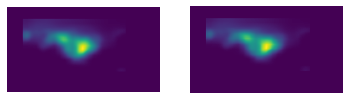

In [17]:
image_util.image_show(highres_cam_stack[0], cam_stack[0], idx=(1,2))


In [ ]:
print(crop_boxes)

[[tensor([52]), tensor([42]), tensor([388]), tensor([214])], [tensor([0]), tensor([133]), tensor([315]), tensor([269])]]


(34, 79)
(281, 500)


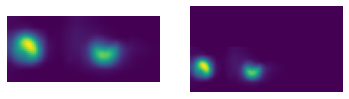

In [ ]:
print(strided_cam.shape)
print(highres_cam.shape)
image_util.image_show(strided_cam, highres_cam, idx =(1,2))

In [ ]:
temp_cam.shape

torch.Size([1, 136, 315])

In [20]:
model = getattr(importlib.import_module(cam_network), 'CAM')()
model.load_state_dict(torch.load(cam_weights_name + '.pth'), strict=True)        
model.eval()
    
dataset = voc12.dataloader.VOC12ClassificationDatasetMSF(trainval_list, voc12_root = voc12_root, scales=cam_scales)

In [21]:
data_loader = DataLoader(dataset)

pack = next(iter(data_loader))

In [22]:
with torch.no_grad():
    model = model.to(device)


    img_name = pack['name'][0]
    label = pack['label'][0]
    size = pack['size']
    image = pack['img'] # 4 MSF images [2, 3, w, h]
    strided_size = imutils.get_strided_size(size, 4)
    strided_up_size = imutils.get_strided_up_size(size, 16)
    
    outputs = [model(img[0].to(device))
                for img in pack['img']]
    
    
    strided_cam = torch.sum(torch.stack(
        [F.interpolate(torch.unsqueeze(o, 0), strided_size, mode='bilinear', align_corners=False)[0] for o
            in outputs]), 0)


    highres_cam = [F.interpolate(torch.unsqueeze(o, 1), strided_up_size,
                                    mode='bilinear', align_corners=False) for o in outputs]
    highres_cam = torch.sum(torch.stack(highres_cam, 0), 0)[:, 0, :size[0], :size[1]]

    valid_cat = torch.nonzero(label)[:, 0]

    strided_cam = strided_cam[valid_cat]
    strided_cam /= F.adaptive_max_pool2d(strided_cam, (1, 1)) + 1e-5

    highres_cam = highres_cam[valid_cat]
    highres_cam /= F.adaptive_max_pool2d(highres_cam, (1, 1)) + 1e-5

In [24]:
strided_cam.cpu().shape

torch.Size([2, 71, 125])

In [ ]:
crop_boxes

[[tensor([52]), tensor([42]), tensor([388]), tensor([214])],
 [tensor([0]), tensor([133]), tensor([315]), tensor([269])]]

In [ ]:
def resize_bbox(bbox, original_img_size, new_img_size):

    x1, y1, x2, y2 = bbox
    original_width, original_height = original_img_size
    new_width, new_height = new_img_size

    # Calculate the ratio of old size to new size
    width_ratio = new_width / original_width
    height_ratio = new_height / original_height

    # Resize the bounding box coordinates
    x1_new = int(x1 * width_ratio)
    y1_new = int(y1 * height_ratio)
    x2_new = int(x2 * width_ratio)
    y2_new = int(y2 * height_ratio)

    return (x1_new, y1_new, x2_new, y2_new)

# 예시
original_bbox = (0, 133, 315, 269)
original_img_size = (281, 500)
new_img_size = (71, 125)

resized_bbox = resize_bbox(original_bbox, original_img_size, new_img_size)
print(resized_bbox)  # 출력: (16, 25, 119, 66)

(0, 33, 79, 67)


In [ ]:
resized_bbox = image_util.resize_bbox_list(crop_boxes, (281, 500), (71, 125))

In [ ]:
resized_bbox

[(13, 10, 98, 53), (0, 33, 79, 67)]